# FTIR Peak Deviation Regression

Predict spectral peak shift and magnitude deviation caused by defects in metasurface arrays.

**Objective**: Given where defects are and what kind they are, how much do they perturb the dominant FTIR peak?

- **Targets**: `delta_peak_wl`, `delta_peak_mag` (relative to zero-defect baseline)
- **Inputs**: defect type counts, defect distance geometry, global spatial context
- **No spectral inputs, no leakage**

---

In [1]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os, sys
from pathlib import Path

# Resolve project root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Define base directory explicitly
BASE_DIR = str(PROJECT_ROOT)

# Directory containing FTIR .dpt files
FTIR_DIR = os.path.join(BASE_DIR, "data")

# Ensure project root is on path
if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

from defect_analysis.ml import ftir_utils, feature_extraction, dataset_assembly, ml_models

plt.rcParams.update({
    "figure.dpi": 120, "font.size": 10, "axes.titlesize": 12,
    "axes.labelsize": 10, "figure.facecolor": "white",
})

CSV_PATH = os.path.join(BASE_DIR, "results", "meta_atoms_classified.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "ml_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"FTIR data dir: {FTIR_DIR}")
print(f"Classification CSV: {CSV_PATH}")

Project root: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects
FTIR data dir: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\data
Classification CSV: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\results\meta_atoms_classified.csv


## Step 1 -- Visualization of Global Trends (Context)

We visualize the **Global Mean Spectrum** for each array to understand overall behavior.
**Note**: For regression targets (Step 2), we use a **Local Neighbor Baseline** to robustly isolate defects from smooth illumination variations.


In [2]:
# Load FTIR data
array_data = ftir_utils.load_all_arrays(FTIR_DIR)
for stem, (wl, sp) in array_data.items():
    print(f'{stem}: {sp.shape[1]} spectra, {sp.shape[0]} spectral points, '
          f'wavelength {wl[0]:.2f}-{wl[-1]:.2f} um')

# Load classifications
classifications = ftir_utils.load_classifications(CSV_PATH)
for arr_name, pillar_map in classifications.items():
    defect_counts = {}
    for dt in pillar_map.values():
        defect_counts[dt] = defect_counts.get(dt, 0) + 1
    print(f'{arr_name}: {defect_counts}')

Array_1.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_2.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_3.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_4.0: 169 spectra, 1763 spectral points, wavelength 2.50-16.67 um
Array_1Crop: {'Good': 340, 'Missing': 31, 'Collapsed': 31, 'Stitching': 36, 'Irregular': 3}
Array_2Crop: {'Good': 390, 'Stitching': 19, 'Irregular': 7, 'Missing': 15, 'Collapsed': 10}
Array_3Crop: {'Good': 367, 'Missing': 24, 'Irregular': 8, 'Collapsed': 30, 'Stitching': 12}


### 1.2 Identify zero-defect windows and compute baselines

In [3]:
# Build window compositions for all arrays
array_stems_labeled = ['Array_1.0', 'Array_2.0', 'Array_3.0']
wl_ref = array_data[array_stems_labeled[0]][0]

baselines = {}
zero_defect_counts = {}

for stem in array_stems_labeled:
    wl, sp = array_data[stem]
    comps = ftir_utils.build_all_window_compositions(classifications, stem)
    comp_df = pd.DataFrame(comps)
    
    # Use global mean as baseline (robust to arrays with no zero-defect windows)
    ref_indices = np.arange(sp.shape[1])  # Use ALL spectra
    
    # Keep counting zero defects for stats/reporting
    zero_mask = comp_df['is_zero_defect'].values
    zero_indices = np.where(zero_mask)[0]
    zero_defect_counts[stem] = len(zero_indices)
    
    # Compute baseline from ALL indices (Array Mean)
    ideal_spec, ideal_wl, ideal_mag, _ = feature_extraction.compute_ideal_baseline(
        wl, sp, ref_indices
    )
    baselines[stem] = {
        'ideal_spectrum': ideal_spec,
        'ideal_peak_wl': ideal_wl,
        'ideal_peak_mag': ideal_mag,
        'n_zero_defect': len(zero_indices),
    }
    
    print(f'{stem}: {len(zero_indices)}/169 zero-defect windows')
    print(f'  Ideal peak: {ideal_wl:.4f} um, magnitude: {ideal_mag:.6f}')

Array_1.0: 0/169 zero-defect windows
  Ideal peak: 7.2623 um, magnitude: 0.466492
Array_2.0: 0/169 zero-defect windows
  Ideal peak: 7.3759 um, magnitude: 0.528378
Array_3.0: 0/169 zero-defect windows
  Ideal peak: 7.3654 um, magnitude: 0.500711


### 1.3 Visualize ideal spectra and reference peaks

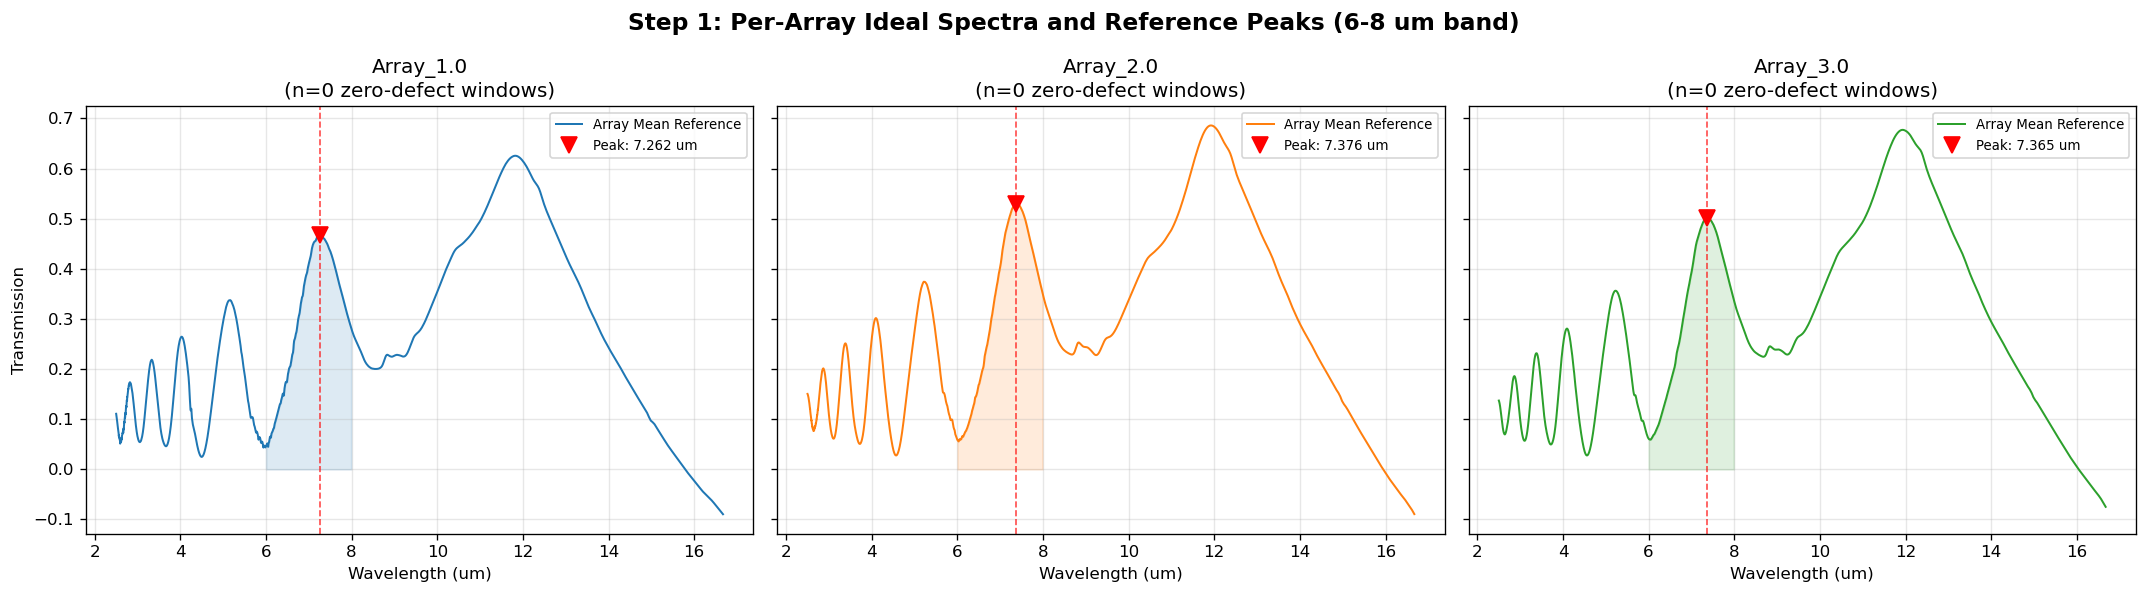

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
colors_arr = ['#1f77b4', '#ff7f0e', '#2ca02c']

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    bl = baselines[stem]
    wl = array_data[stem][0]
    
    # Full ideal spectrum
    ax.plot(wl, bl['ideal_spectrum'], color=color, linewidth=1.2, label='Array Mean Reference')
    
    # Highlight 6-8 um band
    band_mask = feature_extraction.get_band_mask(wl)
    ax.fill_between(wl[band_mask], 0, bl['ideal_spectrum'][band_mask],
                    alpha=0.15, color=color)
    
    # Mark the reference peak
    ax.axvline(bl['ideal_peak_wl'], color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.plot(bl['ideal_peak_wl'], bl['ideal_peak_mag'], 'rv', markersize=10,
            label=f'Peak: {bl["ideal_peak_wl"]:.3f} um')
    
    ax.set_title(f'{stem}\n(n={bl["n_zero_defect"]} zero-defect windows)')
    ax.set_xlabel('Wavelength (um)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transmission')
fig.suptitle('Step 1: Per-Array Ideal Spectra and Reference Peaks (6-8 um band)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step1_ideal_spectra.png'), dpi=150, bbox_inches='tight')
plt.show()

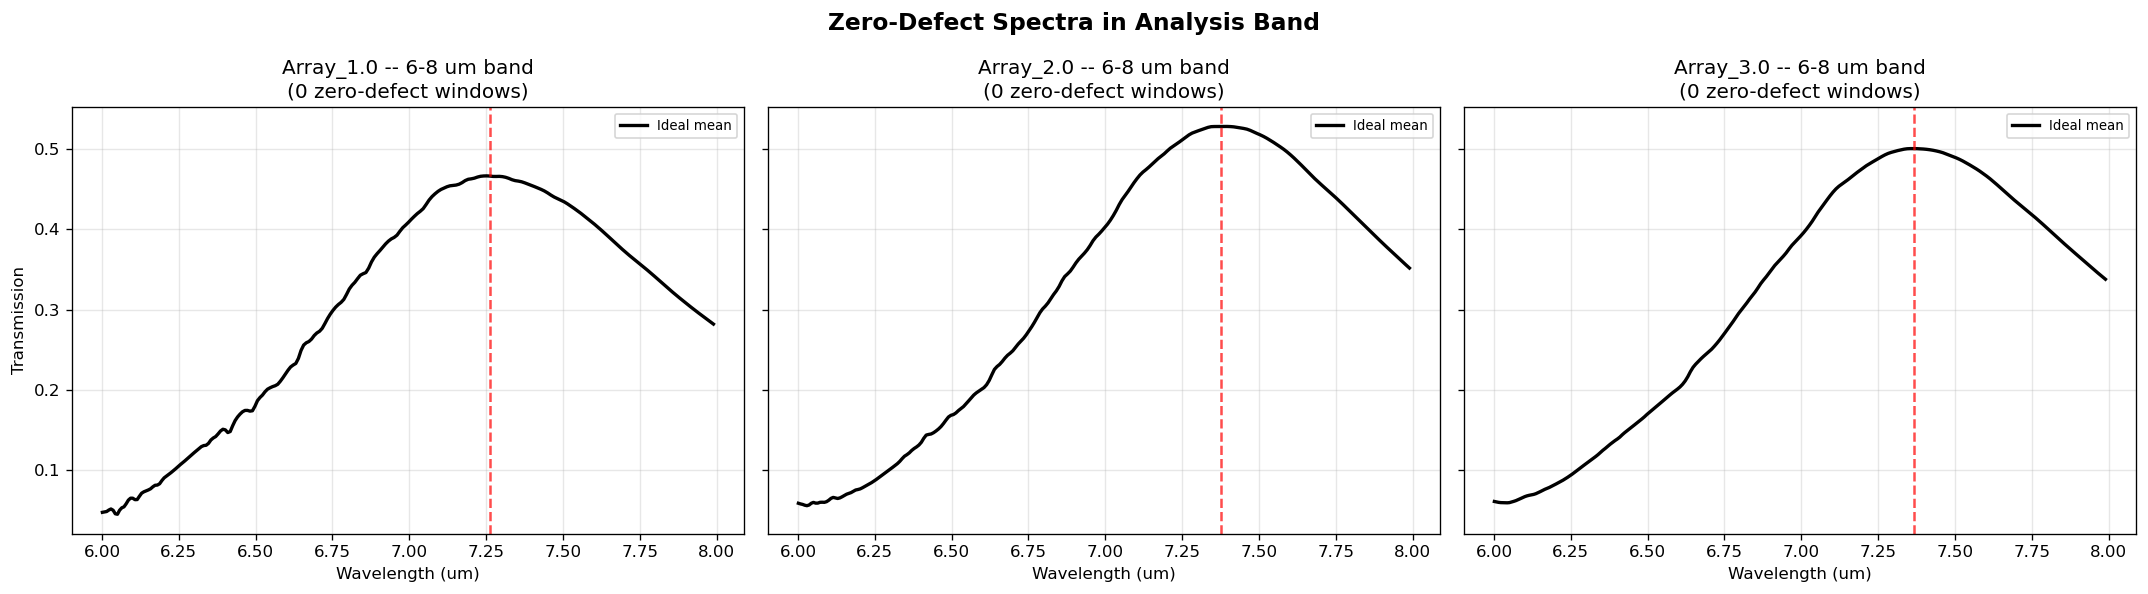

In [5]:
# Zoomed view: 6-8 um band with individual zero-defect spectra
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    wl, sp = array_data[stem]
    comps = ftir_utils.build_all_window_compositions(classifications, stem)
    comp_df = pd.DataFrame(comps)
    zero_indices = np.where(comp_df['is_zero_defect'].values)[0]
    
    band_mask = feature_extraction.get_band_mask(wl)
    wl_band = wl[band_mask]
    
    # Plot individual zero-defect spectra
    for idx in zero_indices:
        ax.plot(wl_band, sp[band_mask, idx], color=color, alpha=0.15, linewidth=0.5)
    
    # Ideal mean
    bl = baselines[stem]
    ax.plot(wl_band, bl['ideal_spectrum'][band_mask], color='black', linewidth=2,
            label='Ideal mean')
    ax.axvline(bl['ideal_peak_wl'], color='red', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{stem} -- 6-8 um band\n({len(zero_indices)} zero-defect windows)')
    ax.set_xlabel('Wavelength (um)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transmission')
fig.suptitle('Zero-Defect Spectra in Analysis Band', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step1_zero_defect_band.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 2 -- Refined Target Variables (Local + Spatial Removal)

We compute advanced targets to handle illumination non-uniformity:
1. **Local Delta**: `val - mean(neighbors)` (Cancels smooth field)
2. **Spatial Residual**: Subtract fitted polynomial field from Local Delta Magnitude.
3. **Relative Metrics**: Extract `peak_prominence`.

### 2.1 Build the dataset with refined targets


In [6]:
print('Building master dataset...')
master_df, bl_info = dataset_assembly.build_master_dataset(array_data, classifications)
print(f'\nMaster dataset: {master_df.shape[0]} rows, {master_df.shape[1]} columns')
print(f'Columns: {list(master_df.columns)}')
master_df.head(10)

Building master dataset...
  Assembling Array_1.0 ...
    Processed 169 measurements.
  Assembling Array_2.0 ...
    Processed 169 measurements.
  Assembling Array_3.0 ...
    Processed 169 measurements.

Master dataset: 507 rows, 37 columns
Columns: ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects', 'is_zero_defect', 'min_defect_dist', 'mean_defect_dist', 'sum_1_over_dist', 'meas_idx', 'local_i', 'local_j', 'global_row', 'global_col', 'dist_from_center', 'n_clusters_dbscan', 'largest_cluster_size', 'mean_cluster_size', 'cluster_density', 'defect_principal_axis_ratio', 'defect_principal_axis_angle', 'alignment_score', 'max_defect_free_chord', 'defect_graph_components', 'avg_graph_degree', 'defect_centroid_offset', 'quadrant_imbalance', 'raw_peak_wl', 'raw_peak_mag', 'peak_prominence', 'delta_peak_wl', 'delta_peak_mag_raw', 'delta_peak_mag', 'array_id', 'array', 'norm_row', 'norm_col']


,n_missing,n_collapsed,n_stitching,n_irregular,n_total_defects,is_zero_defect,min_defect_dist,mean_defect_dist,sum_1_over_dist,meas_idx,...,raw_peak_wl,raw_peak_mag,peak_prominence,delta_peak_wl,delta_peak_mag_raw,delta_peak_mag,array_id,array,norm_row,norm_col
0,8,7,0,0,15,False,26.832816,42.980325,0.375006,1,...,7.142232,0.621628,0.279668,-0.069544,-0.032081,-0.020638,1,Array_1.0,0.75,-1.000000
1,8,7,0,1,16,False,24.000000,46.267082,0.378593,2,...,7.201751,0.649563,0.290586,-0.004150,-0.009644,-0.003482,1,Array_1.0,0.75,-0.833333
2,8,4,9,1,22,False,24.000000,50.277139,0.478022,3,...,7.221812,0.671166,0.301617,-0.004051,-0.016430,-0.014355,1,Array_1.0,0.75,-0.666667
3,6,2,18,1,27,False,26.832816,48.762619,0.592331,4,...,7.231884,0.702624,0.319014,-0.004051,-0.004835,-0.005651,1,Array_1.0,0.75,-0.500000
4,6,2,18,1,27,False,24.000000,42.844008,0.677207,5,...,7.231884,0.713251,0.321289,-0.016189,-0.010784,-0.013298,1,Array_1.0,0.75,-0.333333
5,6,2,18,1,27,False,12.000000,37.920684,0.838401,6,...,7.252113,0.716359,0.319391,-0.000017,-0.014159,-0.017175,1,Array_1.0,0.75,-0.166667
6,6,3,18,1,28,False,0.000000,34.910120,1.776979,7,...,7.252113,0.720054,0.321177,-0.006094,-0.013050,-0.015375,1,Array_1.0,0.75,0.000000
7,5,5,18,1,29,False,0.000000,34.907863,1.809613,8,...,7.252113,0.721594,0.321174,-0.006094,-0.008312,-0.008750,1,Array_1.0,0.75,0.166667
8,4,6,18,1,29,False,12.000000,36.265737,0.929719,9,...,7.252113,0.709309,0.313819,-0.002037,-0.005440,-0.002797,1,Array_1.0,0.75,0.333333
9,4,6,18,1,29,False,12.000000,39.254730,0.844025,10,...,7.241984,0.676231,0.296013,-0.002054,-0.005803,0.001116,1,Array_1.0,0.75,0.500000


### 2.2 Target distributions

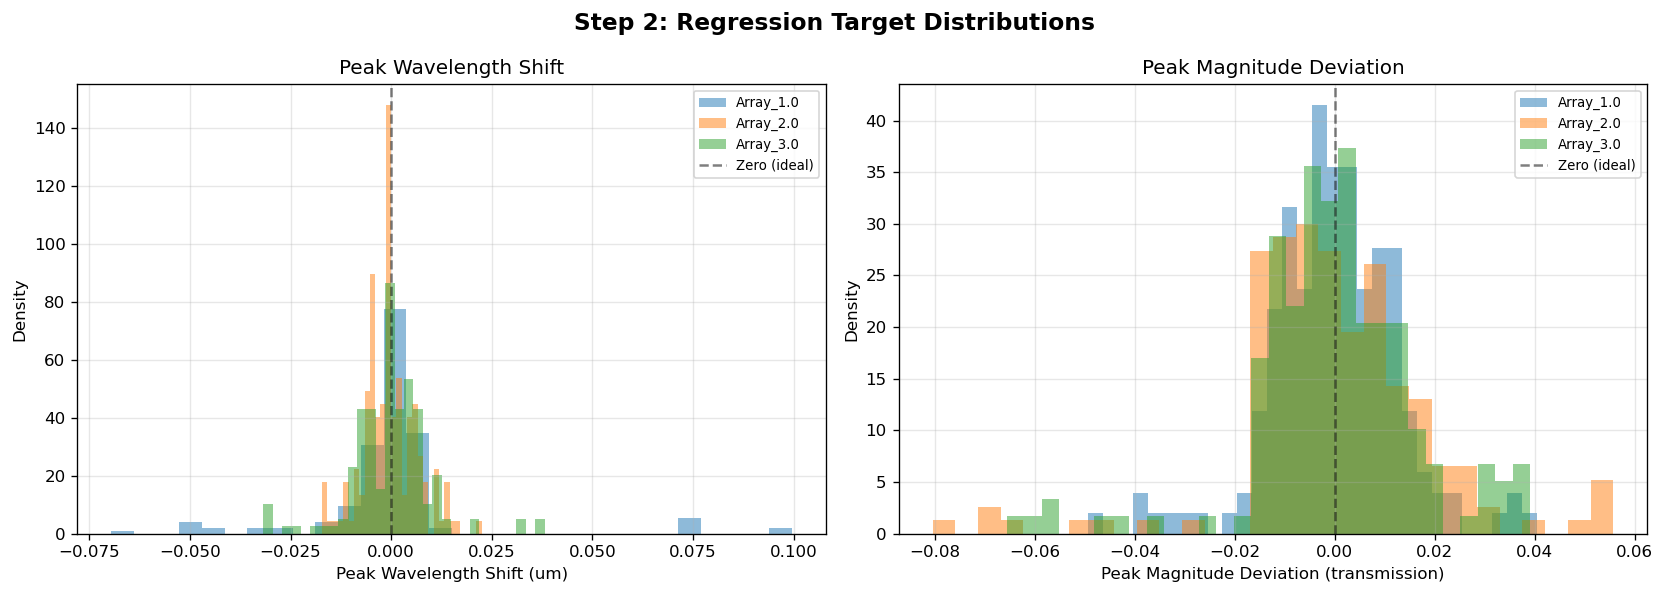

Target statistics:
       delta_peak_wl  delta_peak_mag
count     507.000000    5.070000e+02
mean        0.000104   -4.012788e-17
std         0.013872    1.665117e-02
min        -0.069544   -8.046005e-02
25%        -0.004051   -8.394580e-03
50%         0.000000   -1.900132e-04
75%         0.003936    9.026988e-03
max         0.099594    5.568574e-02


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title, unit in zip(
    axes,
    ['delta_peak_wl', 'delta_peak_mag'],
    ['Peak Wavelength Shift', 'Peak Magnitude Deviation'],
    ['um', 'transmission']
):
    for stem, color in zip(array_stems_labeled, colors_arr):
        vals = master_df.loc[master_df['array'] == stem, col]
        ax.hist(vals, bins=30, alpha=0.5, color=color, label=stem, density=True)
    ax.set_xlabel(f'{title} ({unit})')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero (ideal)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Step 2: Regression Target Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step2_target_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Target statistics:')
print(master_df[['delta_peak_wl', 'delta_peak_mag']].describe())

---
## Step 3 -- Input Features

Strictly controlled: defect counts, defect geometry, global spatial context. No spectral inputs.

### 3.1 Input feature summary

In [8]:

print('Input features (Baseline):')
print(dataset_assembly.BASELINE_INPUT_COLS)
print()
print('Input features (Topology):')
print(dataset_assembly.TOPOLOGY_COLS)
print()
print('Target columns:')
print(dataset_assembly.TARGET_COLS)
print()
print('Feature statistics (Topology):')
print(master_df[dataset_assembly.TOPOLOGY_COLS].describe().round(3))


Input features (Baseline):
['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects', 'min_defect_dist', 'mean_defect_dist', 'sum_1_over_dist', 'global_row', 'global_col', 'dist_from_center', 'norm_row', 'norm_col']

Input features (Topology):
['n_clusters_dbscan', 'largest_cluster_size', 'mean_cluster_size', 'cluster_density', 'defect_principal_axis_ratio', 'defect_principal_axis_angle', 'alignment_score', 'max_defect_free_chord', 'defect_graph_components', 'avg_graph_degree', 'defect_centroid_offset', 'quadrant_imbalance']

Target columns:
['delta_peak_wl', 'delta_peak_mag', 'peak_prominence']

Feature statistics (Topology):
       n_clusters_dbscan  largest_cluster_size  mean_cluster_size  \
count            507.000               507.000            507.000   
mean               2.424                10.146              7.203   
std                1.259                 7.125              5.850   
min                0.000                 1.000              1.000   
2

### 3.2 Defect composition across measurement windows

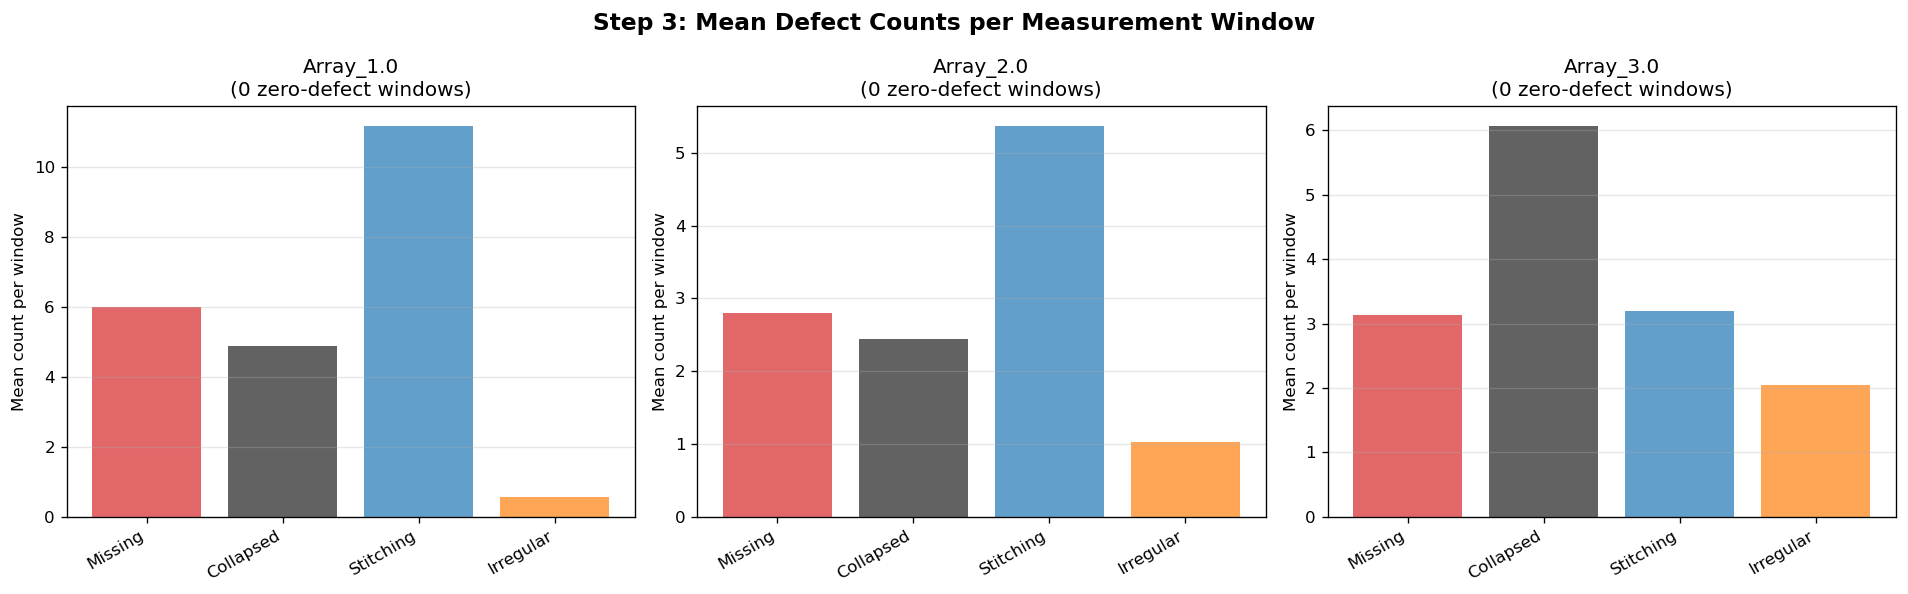

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, stem, color in zip(axes, array_stems_labeled, colors_arr):
    arr_df = master_df[master_df['array'] == stem]
    defect_cols = ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular']
    means = arr_df[defect_cols].mean()
    ax.bar(range(len(defect_cols)), means.values,
           color=['#d62728', '#1f1f1f', '#1f77b4', '#ff7f0e'], alpha=0.7)
    ax.set_xticks(range(len(defect_cols)))
    ax.set_xticklabels(['Missing', 'Collapsed', 'Stitching', 'Irregular'],
                        rotation=30, ha='right')
    ax.set_ylabel('Mean count per window')
    ax.set_title(f'{stem}\n({int(arr_df["is_zero_defect"].sum())} zero-defect windows)')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Step 3: Mean Defect Counts per Measurement Window', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step3_defect_composition.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Spatial maps: defect count and target values over the 13x13 grid

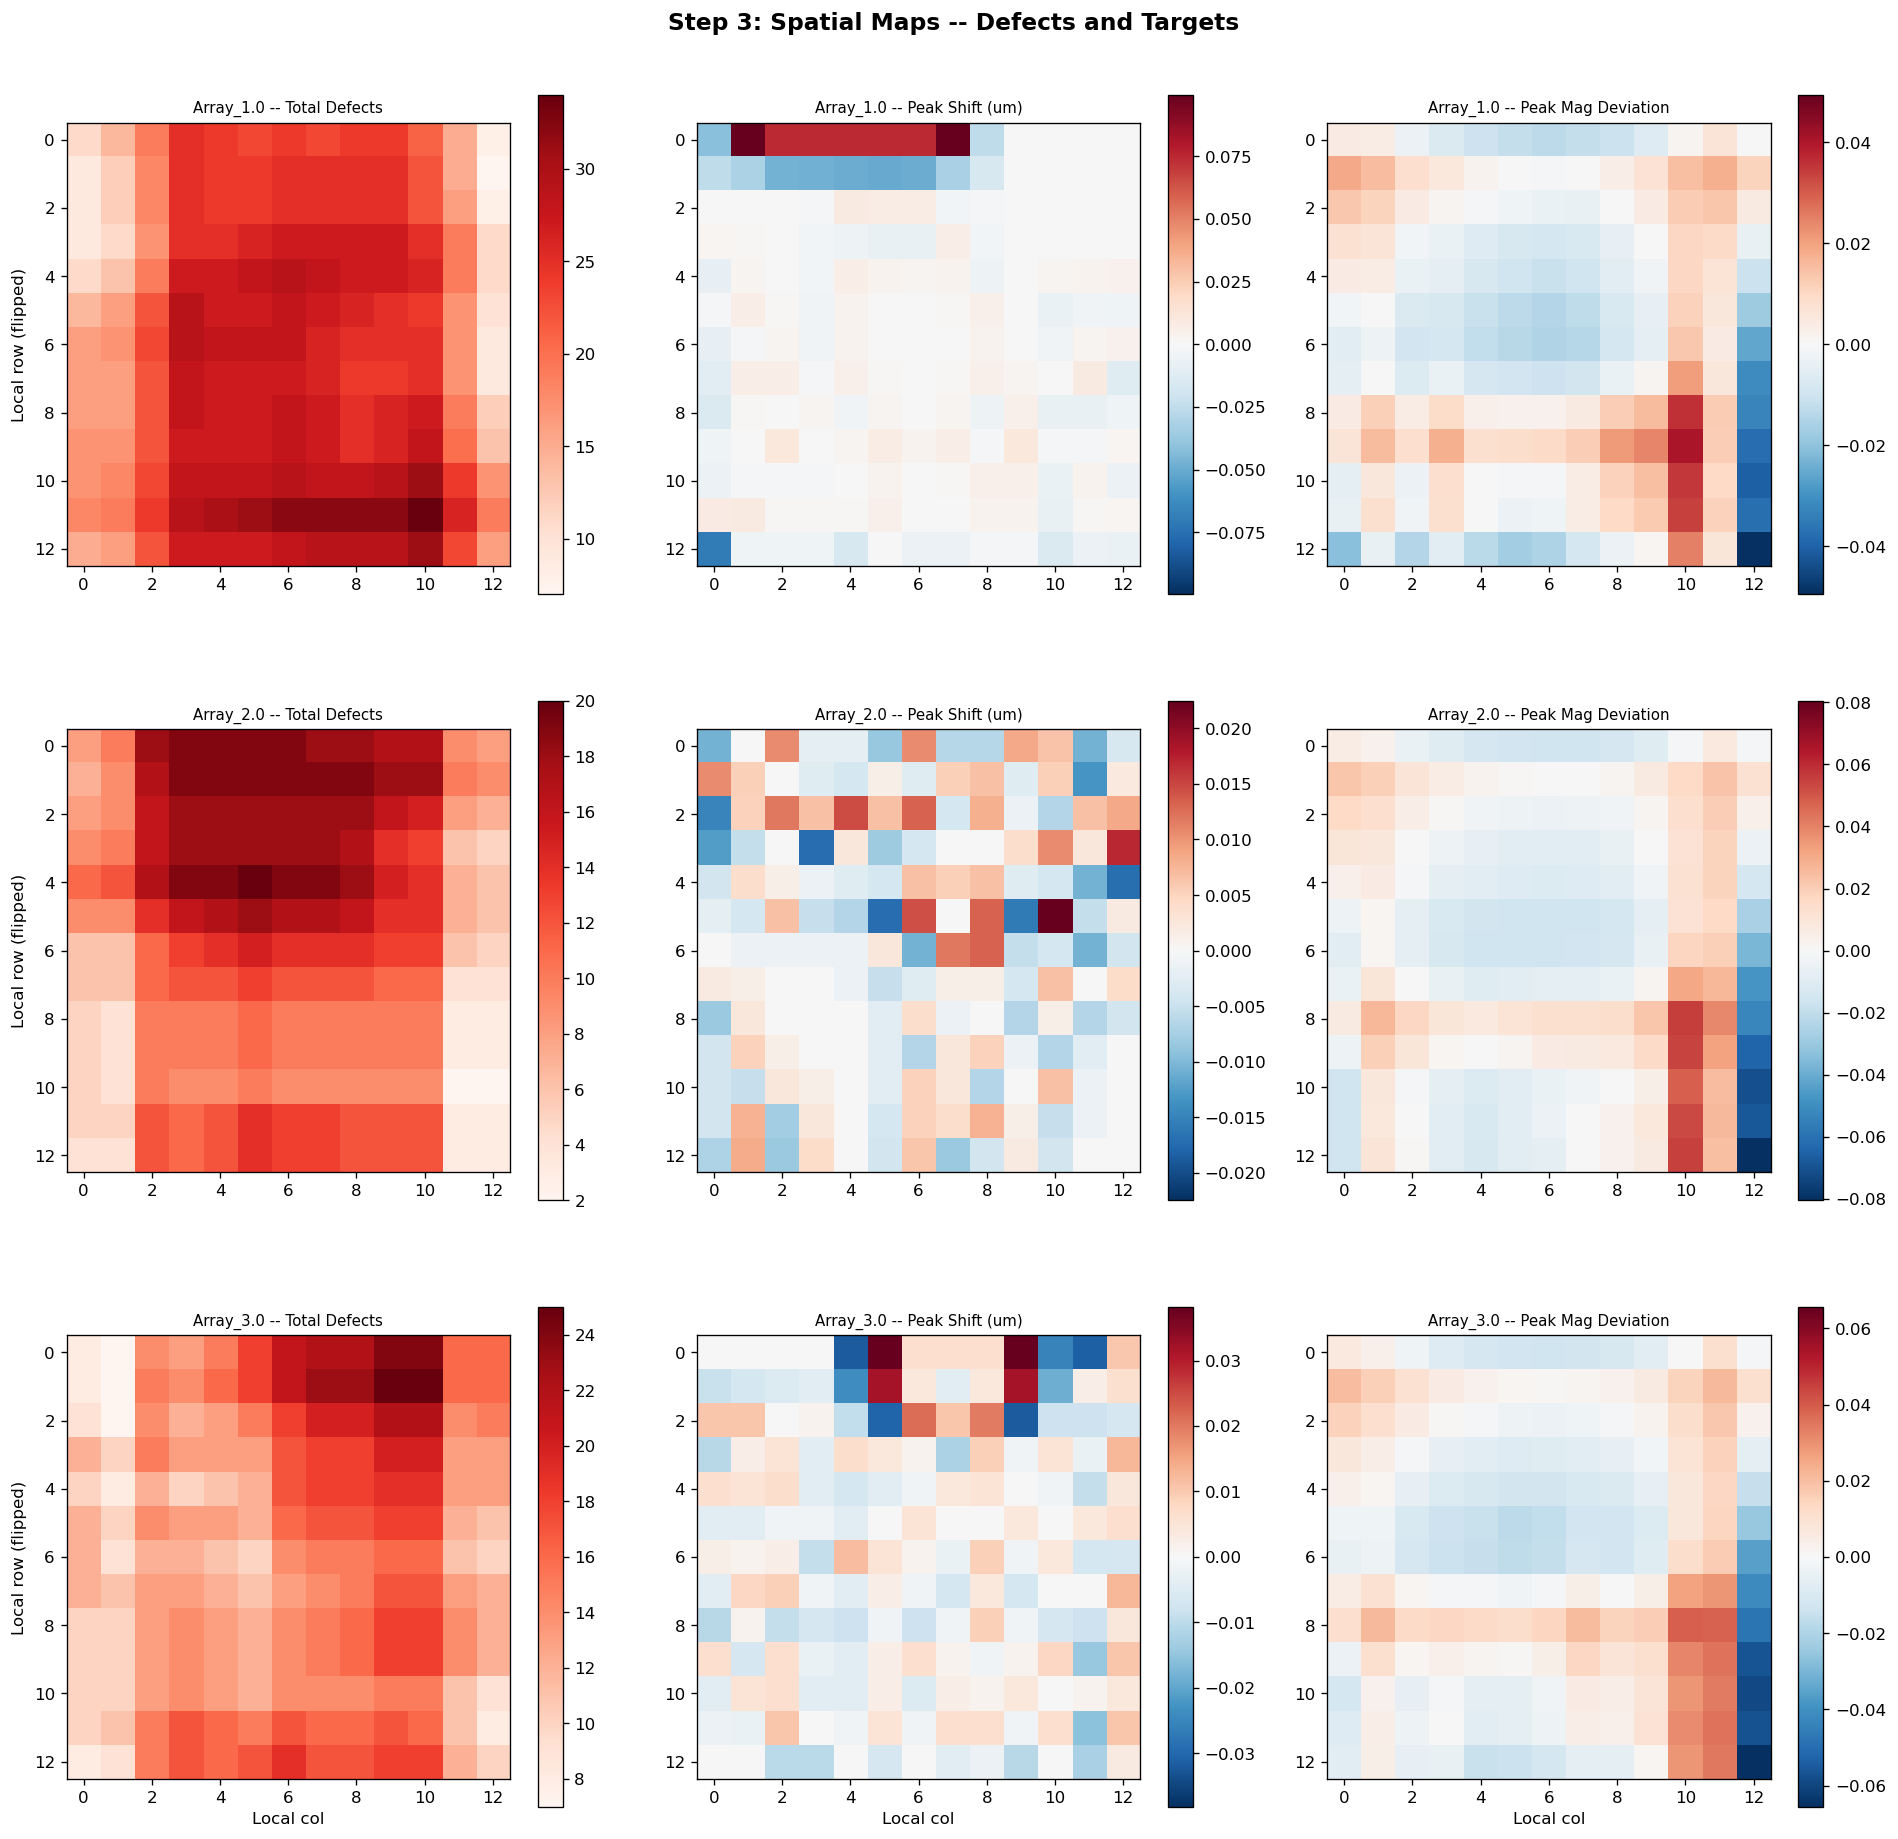

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

plot_vars = ['n_total_defects', 'delta_peak_wl', 'delta_peak_mag']
cmaps = ['Reds', 'RdBu_r', 'RdBu_r']
titles = ['Total Defects', 'Peak Shift (um)', 'Peak Mag Deviation']

for col_idx, (var, cmap, title) in enumerate(zip(plot_vars, cmaps, titles)):
    for row_idx, stem in enumerate(array_stems_labeled):
        ax = axes[row_idx, col_idx]
        arr_df = master_df[master_df['array'] == stem]
        
        grid = np.full((13, 13), np.nan)
        for _, row in arr_df.iterrows():
            i, j = int(row['local_i']), int(row['local_j'])
            grid[12 - i, j] = row[var]  # flip for display
        
        if var == 'n_total_defects':
            im = ax.imshow(grid, cmap=cmap, aspect='equal')
        else:
            vmax = np.nanmax(np.abs(grid))
            im = ax.imshow(grid, cmap=cmap, aspect='equal',
                          vmin=-vmax, vmax=vmax)
        
        ax.set_title(f'{stem} -- {title}', fontsize=9)
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        if col_idx == 0:
            ax.set_ylabel('Local row (flipped)')
        if row_idx == 2:
            ax.set_xlabel('Local col')

fig.suptitle('Step 3: Spatial Maps -- Defects and Targets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step3_spatial_maps.png'), dpi=150, bbox_inches='tight')
plt.show()

---
## Step 4 -- Dataset Structure and Save

Verify final dataset structure and save.

In [11]:
# Handle NaN in distance features (zero-defect windows have NaN distances)
# Fill with sentinel values that reflect "no defect nearby"
dist_fill = {
    'min_defect_dist': master_df['min_defect_dist'].max() * 2 if master_df['min_defect_dist'].notna().any() else 999.0,
    'mean_defect_dist': master_df['mean_defect_dist'].max() * 2 if master_df['mean_defect_dist'].notna().any() else 999.0,
}
master_filled = master_df.copy()
master_filled.fillna(dist_fill, inplace=True)

# Save
master_path = os.path.join(OUTPUT_DIR, 'regression_dataset.csv')
master_filled.to_csv(master_path, index=False)
print(f'Saved: {master_path} ({len(master_filled)} rows)')

# Show the final structure
print(f'\nDataset columns ({len(master_filled.columns)}):')
for c in master_filled.columns:
    role = 'TARGET' if c in dataset_assembly.TARGET_COLS else \
           'INPUT' if c in dataset_assembly.INPUT_COLS else 'META'
    print(f'  [{role:6s}] {c}')

print(f'\nInput features: {len(dataset_assembly.INPUT_COLS)}')
print(f'Targets: {len(dataset_assembly.TARGET_COLS)}')
print(f'Total rows: {len(master_filled)}')

Saved: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects\ml_outputs\regression_dataset.csv (507 rows)

Dataset columns (37):
  [INPUT ] n_missing
  [INPUT ] n_collapsed
  [INPUT ] n_stitching
  [INPUT ] n_irregular
  [INPUT ] n_total_defects
  [META  ] is_zero_defect
  [INPUT ] min_defect_dist
  [INPUT ] mean_defect_dist
  [INPUT ] sum_1_over_dist
  [META  ] meas_idx
  [META  ] local_i
  [META  ] local_j
  [INPUT ] global_row
  [INPUT ] global_col
  [INPUT ] dist_from_center
  [INPUT ] n_clusters_dbscan
  [INPUT ] largest_cluster_size
  [INPUT ] mean_cluster_size
  [INPUT ] cluster_density
  [INPUT ] defect_principal_axis_ratio
  [INPUT ] defect_principal_axis_angle
  [INPUT ] alignment_score
  [INPUT ] max_defect_free_chord
  [INPUT ] defect_graph_components
  [INPUT ] avg_graph_degree
  [INPUT ] defect_centroid_offset
  [INPUT ] quadrant_imbalance
  [META  ] raw_peak_wl
  [META  ] raw_peak_mag
  [TARGET] peak_prominence
  [TARGET] delta_peak_wl
  [M

## Step 5 -- Regression Models

Predicting:
- `delta_peak_wl` (Local Deviation)
- `delta_peak_mag` (Local Deviation + Spatial Residual)
- `peak_prominence` (Relative Metric)


In [12]:

print('=== FEATURE GROUP ABLATION STUDY ===')
print()

feature_sets = {
    'Baseline': dataset_assembly.BASELINE_INPUT_COLS,
    'Baseline + Topology': dataset_assembly.INPUT_COLS
}

results_summary = []

for target in dataset_assembly.TARGET_COLS:
    print(f'--- Target: {target} ---')
    y = master_filled[target].values
    
    for fs_name, cols in feature_sets.items():
        X = master_filled[cols].values
        
        # Train RF (robust default)
        res = ml_models.train_rf(X, y)
        ml_models.model_summary(res, f'RF ({fs_name})')
        
        results_summary.append({
            'Target': target,
            'Feature Set': fs_name,
            'R2': res['mean_r2'],
            'RMSE': res['mean_rmse'],
            'N_Features': len(cols)
        })
    print()

summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

# Visualization of R2 Delta
pivot_r2 = summary_df.pivot(index='Target', columns='Feature Set', values='R2')
pivot_r2['Delta'] = pivot_r2['Baseline + Topology'] - pivot_r2['Baseline']
print('\nImprovement from Topology:\n', pivot_r2[['Delta']])


=== FEATURE GROUP ABLATION STUDY ===

--- Target: delta_peak_wl ---
  RF (Baseline)    R2=+0.0948  RMSE=0.012901
  RF (Baseline + Topology)  R2=-0.0075  RMSE=0.013611

--- Target: delta_peak_mag ---
  RF (Baseline)    R2=+0.9126  RMSE=0.004853
  RF (Baseline + Topology)  R2=+0.8909  RMSE=0.005443

--- Target: peak_prominence ---
  RF (Baseline)    R2=+0.9918  RMSE=0.008893
  RF (Baseline + Topology)  R2=+0.9917  RMSE=0.009031

         Target         Feature Set        R2     RMSE  N_Features
  delta_peak_wl            Baseline  0.094763 0.012901          13
  delta_peak_wl Baseline + Topology -0.007484 0.013611          25
 delta_peak_mag            Baseline  0.912564 0.004853          13
 delta_peak_mag Baseline + Topology  0.890870 0.005443          25
peak_prominence            Baseline  0.991799 0.008893          13
peak_prominence Baseline + Topology  0.991673 0.009031          25

Improvement from Topology:
 Feature Set         Delta
Target                   
delta_peak_mag  -0.

## Step 7 -- Topology Diagnostics

Sanity checks, physics validation, and feature embeddings.

Generating topology diagnostics...


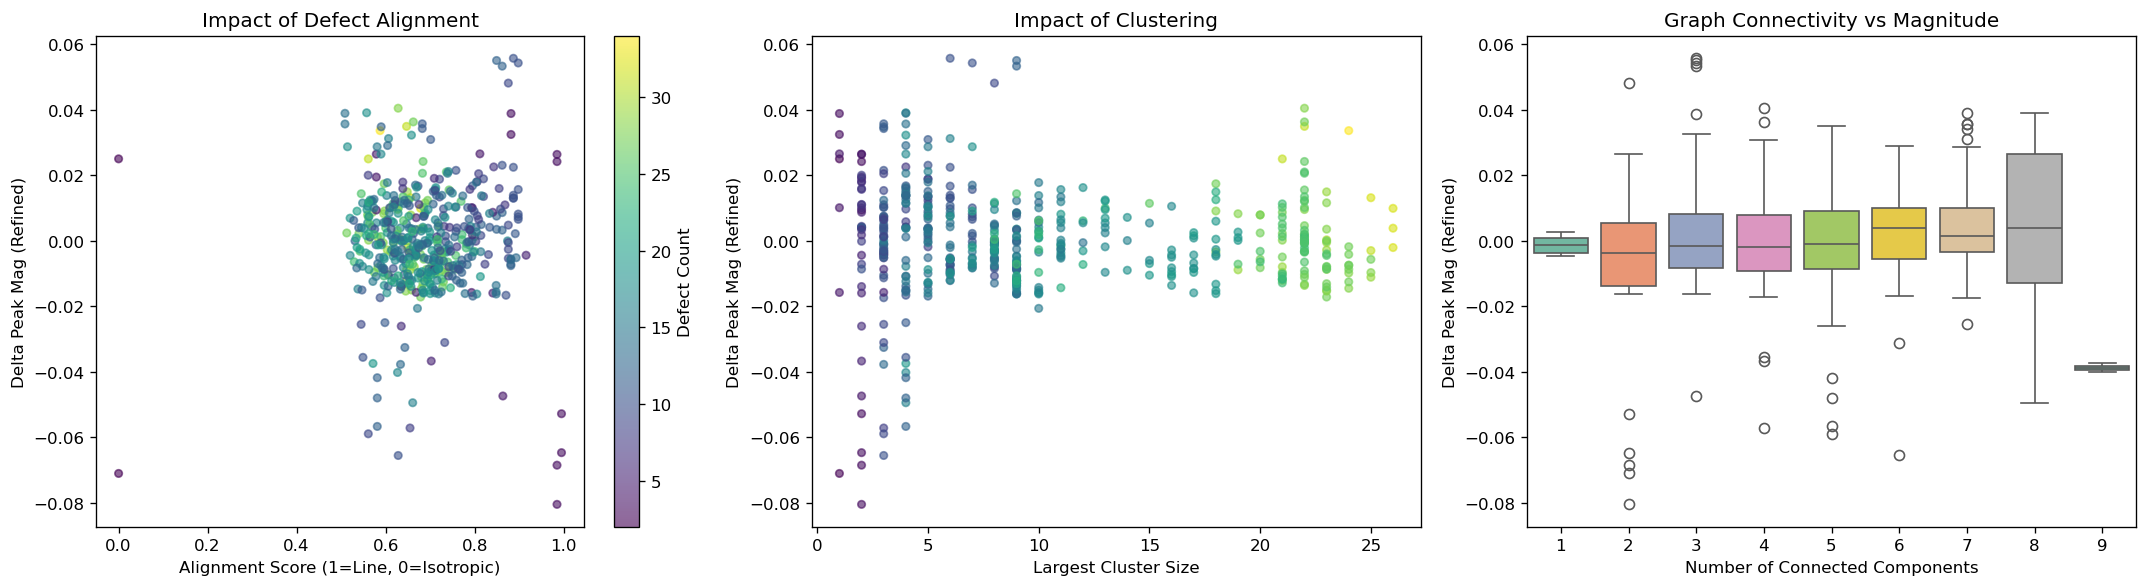

Computing t-SNE on full feature space (Baseline + Topology)...


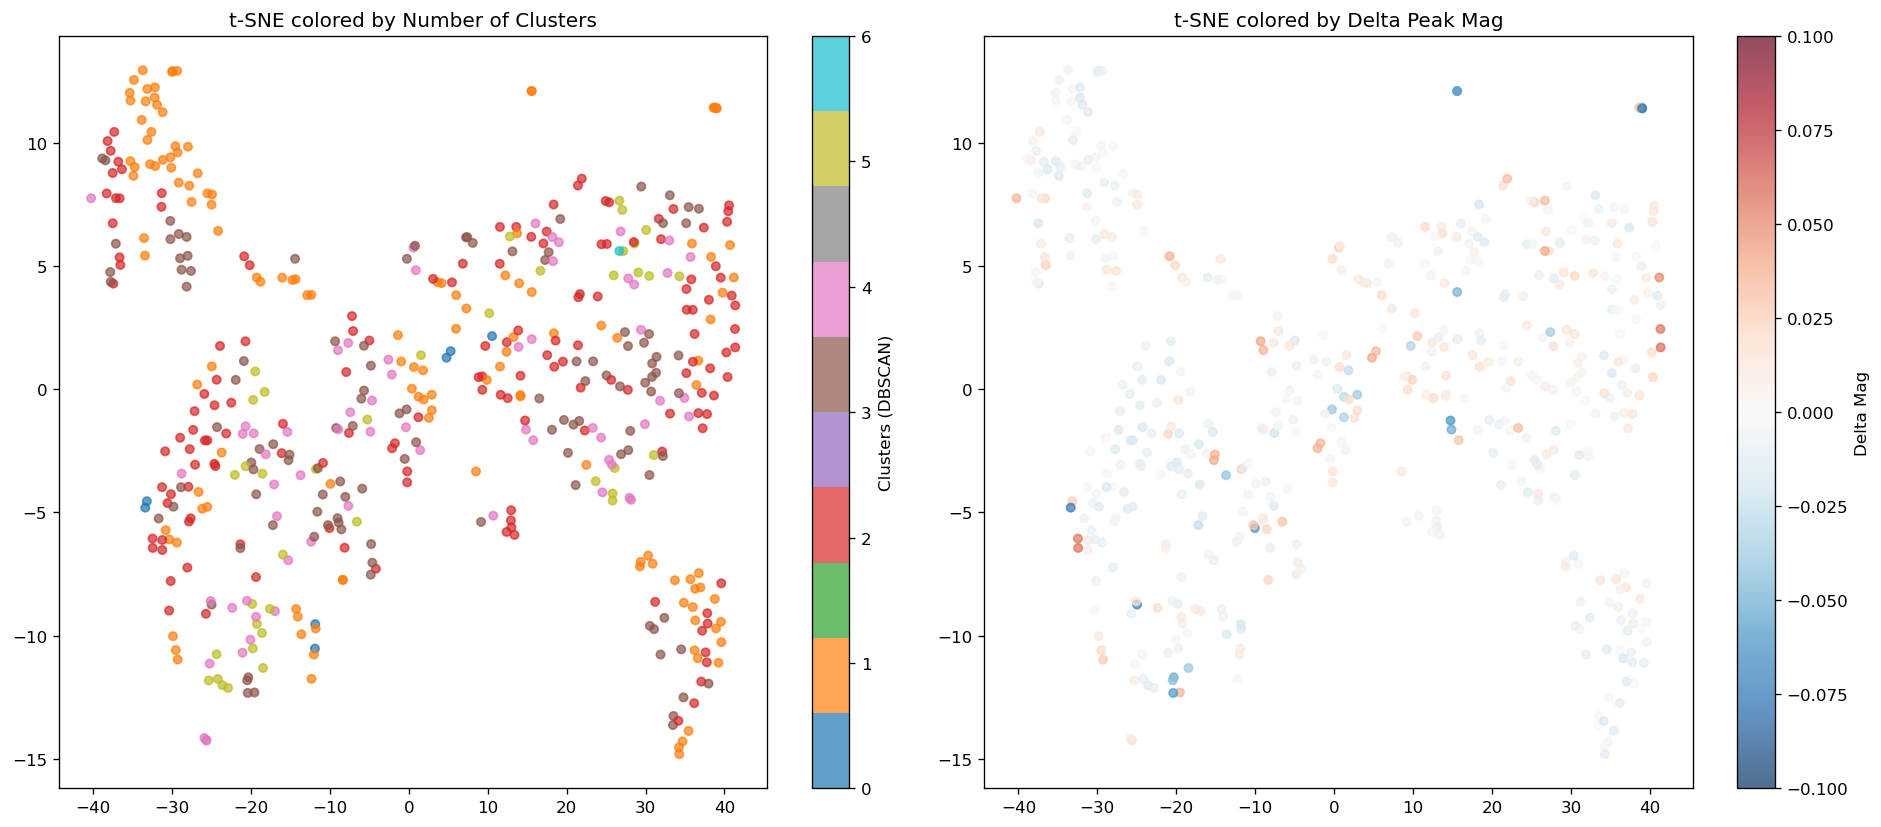

In [13]:

# --- Step 7: Topology Diagnostics ---

from sklearn.manifold import TSNE
import seaborn as sns

print('Generating topology diagnostics...')

# 7.1 Sanity Checks: Target vs Topology Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Alignment Score
ax = axes[0]
sc = ax.scatter(master_filled['alignment_score'], master_filled['delta_peak_mag'], 
                c=master_filled['n_total_defects'], cmap='viridis', s=20, alpha=0.6)
ax.set_xlabel('Alignment Score (1=Line, 0=Isotropic)')
ax.set_ylabel('Delta Peak Mag (Refined)')
ax.set_title('Impact of Defect Alignment')
plt.colorbar(sc, ax=ax, label='Defect Count')

# Clustering impact
ax = axes[1]
sc = ax.scatter(master_filled['largest_cluster_size'], master_filled['delta_peak_mag'],
                c=master_filled['n_total_defects'], cmap='viridis', s=20, alpha=0.6)
ax.set_xlabel('Largest Cluster Size')
ax.set_ylabel('Delta Peak Mag (Refined)')
ax.set_title('Impact of Clustering')

# Graph connectivity
ax = axes[2]
sns.boxplot(x='defect_graph_components', y='delta_peak_mag', data=master_filled, ax=ax, palette='Set2')
ax.set_xlabel('Number of Connected Components')
ax.set_ylabel('Delta Peak Mag (Refined)')
ax.set_title('Graph Connectivity vs Magnitude')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step7_topology_sanity.png'))
plt.show()

# 7.2 t-SNE feature embedding
print('Computing t-SNE on full feature space (Baseline + Topology)...')
X_full = master_filled[dataset_assembly.INPUT_COLS].values
# Fill NaNs if any (though we filled distances earlier, topology might have NaNs?)
# Topology features should be robust (0 for empty).
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_emb = tsne.fit_transform(X_full)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Color by Topology Class (e.g. n_clusters)
ax = axes[0]
sc = ax.scatter(X_emb[:,0], X_emb[:,1], c=master_filled['n_clusters_dbscan'], 
                cmap='tab10', s=25, alpha=0.7)
ax.set_title('t-SNE colored by Number of Clusters')
plt.colorbar(sc, ax=ax, label='Clusters (DBSCAN)')

# Color by Target (Mag)
ax = axes[1]
sc = ax.scatter(X_emb[:,0], X_emb[:,1], c=master_filled['delta_peak_mag'], 
                cmap='RdBu_r', s=25, alpha=0.7, vmin=-0.1, vmax=0.1)
ax.set_title('t-SNE colored by Delta Peak Mag')
plt.colorbar(sc, ax=ax, label='Delta Mag')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'step7_tsne_topology.png'))
plt.show()
